# Video Classification with a CNN-RNN Architecture

**Original Author:** Sayak Paul   
**Date created:** 2021/05/28   
**Last modified:** 2021/06/05    
**Description:** Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset.    

This example demonstrates video classification, an important use-case with applications in recommendations, security, and so on. We will be using the UCF101 dataset to build our video classifier. The dataset consists of videos categorized into different actions, like cricket shot, punching, biking, etc. This dataset is commonly used to build action recognizers, which are an application of video classification.

A video consists of an ordered sequence of frames. Each frame contains spatial information, and the sequence of those frames contains temporal information. To model both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing). Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of GRU layers. This kind of hybrid architecture is popularly known as a CNN-RNN.

In [5]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [22]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 12

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

### Data Collection 

In order to keep the runtime of this example relatively short, we will be using a subsampled version of the original UCF101 dataset. You can refer to this notebook to know how the subsampling was done.

In [6]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

# Data Preparation

*P.S. I already did the preparation and saved it to npy files in order to make the training faster if you want to skip data preparation part.*

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


video_name           tag
495   v_TennisSwing_g10_c06.avi   TennisSwing
160  v_PlayingCello_g14_c02.avi  PlayingCello
455  v_ShavingBeard_g22_c06.avi  ShavingBeard
532   v_TennisSwing_g16_c01.avi   TennisSwing
332         v_Punch_g22_c02.avi         Punch
341         v_Punch_g23_c04.avi         Punch
280         v_Punch_g14_c02.avi         Punch
11    v_CricketShot_g09_c05.avi   CricketShot
486   v_TennisSwing_g09_c04.avi   TennisSwing
445  v_ShavingBeard_g21_c03.avi  ShavingBeard

In [8]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [10]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [12]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [13]:
from datetime import datetime
from pathlib import Path

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

logdir = f"logs/scalars/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

def run_experiment():
    filepath = Path.cwd()
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        batch_size=BATCH_SIZE,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            tensorboard_callback,
        ],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [33]:
history, sequence_model = run_experiment()

Epoch 1/12
7/7 [==============================] - 6s 349ms/step - loss: 1.6094 - accuracy: 0.2458 - val_loss: 1.8301 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.83010, saving model to /home/chainyo/code/video-classification-cnn-rnn
Epoch 2/12
7/7 [==============================] - 0s 16ms/step - loss: 1.5141 - accuracy: 0.3108 - val_loss: 1.7990 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 1.83010 to 1.79903, saving model to /home/chainyo/code/video-classification-cnn-rnn
Epoch 3/12
7/7 [==============================] - 0s 16ms/step - loss: 1.3297 - accuracy: 0.4964 - val_loss: 1.6561 - val_accuracy: 0.0447

Epoch 00003: val_loss improved from 1.79903 to 1.65611, saving model to /home/chainyo/code/video-classification-cnn-rnn
Epoch 4/12
7/7 [==============================] - 0s 16ms/step - loss: 1.1856 - accuracy: 0.5904 - val_loss: 1.5015 - val_accuracy: 0.2291

Epoch 00004: val_loss improved from 1.65611 to 1.50152, saving model to /ho

Test video path: v_Punch_g03_c01.avi
  Punch: 71.19%
  TennisSwing: 17.20%
  PlayingCello:  5.47%
  ShavingBeard:  3.29%
  CricketShot:  2.85%



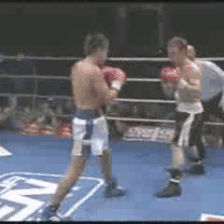

In [34]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

### Export to Hugging Face Hub

In [32]:
from huggingface_hub import push_to_hub_keras

local_path = Path.cwd()
logdir_path = local_path.joinpath("logs")

push_to_hub_keras(
    sequence_model, 
    repo_path_or_name=local_path,
    repo_url="https://huggingface.co/ChainYo/video-classification-cnn-rnn",
)

/home/chainyo/code/video-classification-cnn-rnn is already a clone of https://huggingface.co/ChainYo/video-classification-cnn-rnn. Make sure you pull the latest changes with `repo.git_pull()`.


INFO:tensorflow:Assets written to: /home/chainyo/code/video-classification-cnn-rnn/assets


INFO:tensorflow:Assets written to: /home/chainyo/code/video-classification-cnn-rnn/assets
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.
Upload file saved_model.pb:  81%|████████  | 4.53M/5.60M [00:01<00:00, 4.71MB/s]remote: -------------------------------------------------------------------------        
remote: Your push was rejected because it contains binary files.        
remote: Please use https://git-lfs.github.com/ to store binary files.        
remote: See also: https://hf.co/docs/hub/adding-a-model#uploading-your-files(B        
remote: -------------------------------------------------------------------------        
remote: Offending files:        
remote:  - variables/variables.data-00000-of-00001 (ref: refs/heads/main)        
To https://huggingface.co/ChainYo/video-classification-cnn-rnn
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://huggingface.co/ChainYo/video-classification-c

OSError: remote: -------------------------------------------------------------------------[31m        
remote: Your push was rejected because it contains binary files.        
remote: Please use https://git-lfs.github.com/ to store binary files.        
remote: See also: https://hf.co/docs/hub/adding-a-model#uploading-your-files(B[m        
remote: -------------------------------------------------------------------------        
remote: Offending files:        
remote:  - variables/variables.data-00000-of-00001 (ref: refs/heads/main)        
To https://huggingface.co/ChainYo/video-classification-cnn-rnn
 ! [remote rejected] main -> main (pre-receive hook declined)
error: failed to push some refs to 'https://huggingface.co/ChainYo/video-classification-cnn-rnn'
